# Project: new constructions in France

## Import Packages 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd 
import pysal as ps
import libpysal
from esda import moran, fdr
import contextily as cx
import plotly.express as px
import matplotlib.colors as colors

## Functions 

In [2]:
def com_code(code, dep):
    if len(str(code))==1:
        code="00"+str(code)
    if len(str(code))==2:
        code="0"+str(code)
    code=str(dep)+ str(code)
    return code

In [3]:
def moran_cluster(index_moran):
    kind_cluster='non_significant'
    if index_moran==1:
        kind_cluster='HH'
    elif index_moran==2:
        kind_cluster='LH'
    elif index_moran==3:
        kind_cluster='LL'
    elif index_moran==4:
        kind_cluster='HL'
    return kind_cluster

## Issue 

<b> Where do we build the most in France? </b>

To answer this question, three scales were studied:

-regional

-departmental

-and a more precise case study for the department that was identified as the one where the most construction is taking place: Loire-Atlantique


## Import Data 

The data used are from the sitadel database which lists all the construction projects in France, it is made available in the form of a csv file.
<br> We have decided to base ourselves on the year 2021. </br>

source: 
- https://www.statistiques.developpement-durable.gouv.fr/construction-de-logements-resultats-fin-avril-2022-france-entiere?rubrique=&dossier=1047
- https://www.insee.fr/fr/statistiques/6011060?sommaire=6011075


In [4]:
sitadel=pd.read_csv('PC_DP_créant_logements_2021.txt', sep='\t', encoding='latin-1', low_memory=False)

In [5]:
sitadel.head()

,REG,DEP,COMM,Type_DAU,Num_DAU,Etat_DAU,DATE_REELLE_AUTORISATION,DATE_REELLE_DOC,DATE_REELLE_DAACT,DPC_AUT,...,SURF_HAB_AVANT,SURF_HAB_CREEE,SURF_HAB_ISSUE_TRANSFO,SURF_HAB_DEMOLIE,SURF_HAB_TRANSFORMEE,SURF_LOC_AVANT,SURF_LOC_CREEE,SURF_LOC_ISSUE_TRANSFO,SURF_LOC_DEMOLIE,SURF_LOC_TRANSFORMEE
0,82,1,1001,PC,00100120V0010,2,18/01/2021,NaN,NaN,202101,...,0.0,92.0,0.0,0.0,0.0,0,0,0,0,0
1,82,1,1001,PC,00100121V0001,5,16/03/2021,28/06/2021,NaN,202103,...,0.0,112.0,0.0,0.0,0.0,0,0,0,0,0
2,82,1,1001,PC,00100121V0002,2,02/04/2021,NaN,NaN,202104,...,0.0,0.0,142.0,0.0,0.0,142,0,0,0,142
3,82,1,1001,PC,00100121V0003,2,26/04/2021,NaN,NaN,202104,...,0.0,105.0,0.0,0.0,0.0,0,0,0,0,0
4,82,1,1001,PC,00100121V0004,5,12/05/2021,25/11/2021,NaN,202105,...,0.0,103.0,0.0,0.0,0.0,0,0,0,0,0


## Part I: Regional Scale <a class="anchor" id="part_1"></a>

### Group by region <a class="anchor" id="part_1_1"></a>

We have grouped the data by region for comparison 

In [6]:
reg_sitadel=sitadel[['REG', 'Num_DAU']].groupby(['REG'], as_index=False).count()

In [7]:
reg_sitadel['REG']=reg_sitadel['REG'].apply(str)

In [8]:
reg_sitadel['REG']=reg_sitadel['REG'].replace({'1': 'Guadeloupe', '2': 'Martinique', '3': 'Guyane', '4': 'La Reunion','6':'Mayotte', 
                         '11': 'Ile-de-France', '21': 'Grand Est','22': 'Haut-de-France', '23':'Normandie', 
                         '24':'Centre-Val-de-Loire','25': 'Normandie', '26':'Bourgogne-France-Comté', 
                         '31': 'Haut-de-France','41':'Grand Est', '42': 'Grand Est',
                         '43':'Bourgogne-France-Comté', '52': 'Pays de la Loire', '53':'Bretagne',
                        '54':'Nouvelle-Aquitaine', '72':'Nouvelle-Aquitaine', '73':'Occitanie',
                        '74':'Nouvelle-Aquitaine', '82':'Auvergne-Rhone-Alpes', '83':'Auvergne-Rhone-Alpes',
                        '91': 'Occitanie', '93':'Rhone-Alpes-Cote-Azur', '94': 'Corse'})

In [9]:
reg_sitadel=reg_sitadel[['REG', 'Num_DAU']].groupby(['REG'], as_index=False).sum()

In [10]:
reg_sitadel=reg_sitadel.sort_values(by=['Num_DAU'], ascending=True)

### Graphic and Analysis <a class="anchor" id="part_1_2"></a>

In [11]:
fig = px.bar(reg_sitadel, x='REG', y='Num_DAU',  color='REG',
             title="Number of new buildings by region in France in 2021",
             width=1200, height=800,
            labels={
                     "Num_DAU": "Number of constructions",
                     "REG": "Regions",
                 })
fig=fig.update_layout(title_x=0.45)


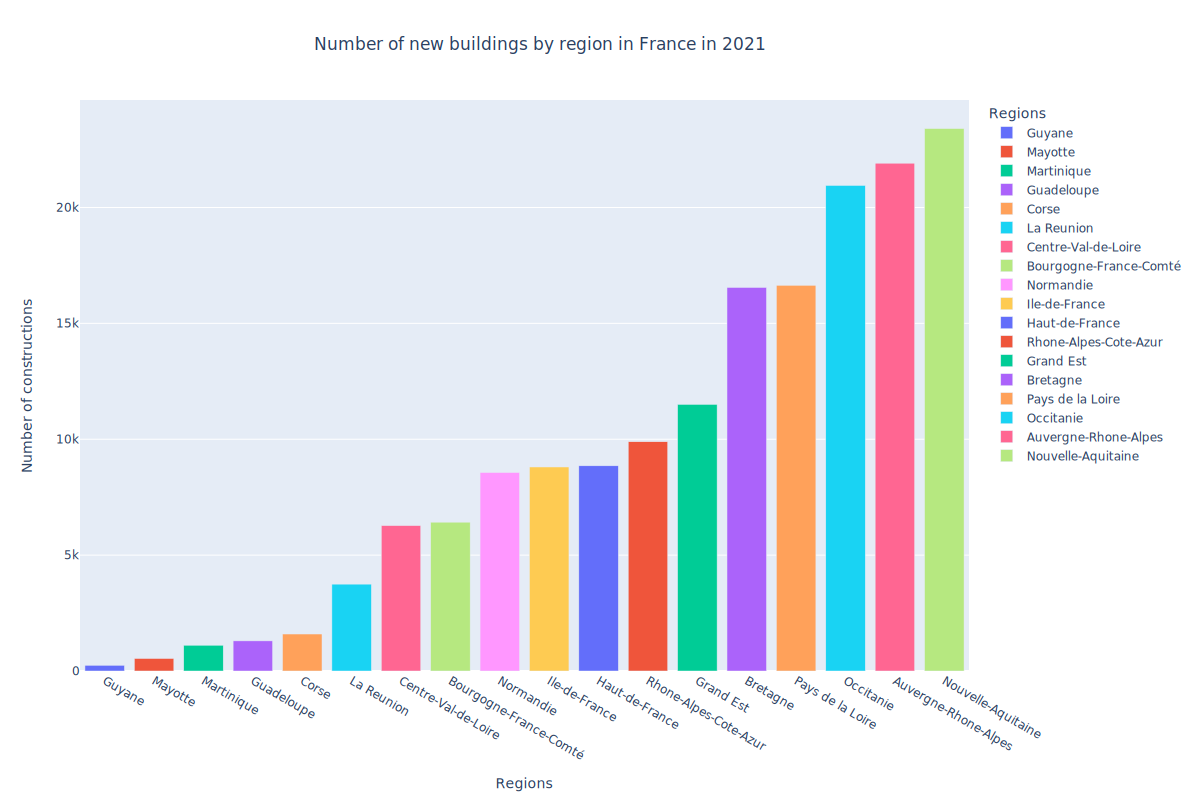

In [12]:
fig.show(renderer="svg")

the regions can be divided into three categories: 
<ul>
<li>very dynamic regions with more than 20,000 constructions in 2021: Nouvelle Aquitaine, Auvergne-Rhône-Alpes and Occitanie</li> 
<li>A second group with a significant number of new constructions around 16,000 in 2021: Pays de la Loire and Bretagne </li>   
<li>and the rest of the regions where the number of new constructions is less than 10,000 in 2021 (except for the Grand Est with a slightly higher figure)</li>
</ul>

## Partie II: Departmental Scale 

### Number of building permits by department 

In [13]:
departement_sitadel=sitadel[['DEP', 'Num_DAU']].groupby(['DEP'], as_index=False).count()

### Top 10 departments with the most building permits 

In [14]:
dep_top=departement_sitadel.sort_values(by=['Num_DAU'], ascending=False).head(10)

In [15]:
dep_top['rank']=dep_top['Num_DAU'].rank(ascending=False, method='min')

In [16]:
dep_top10=dep_top['DEP'].tolist()

### Filter to keep only individual building permits 

In [17]:
sitadel_part=sitadel[sitadel['CAT_DEM'].isin([10,11,12])].copy()

In [18]:
print("the percentage of individual building permits is: " + str(round(len(sitadel_part)/len(sitadel), 2)))

the percentage of individual building permits is: 0.87


### Departments of origin of applicants 

In [19]:
sitadel_part['DEP_D']=sitadel_part.CODPOST_DEM.str[:2]

In [20]:
dep_origine=sitadel_part[['DEP', 'DEP_D', 'Num_DAU']].groupby(['DEP','DEP_D'], as_index=False).count()

In [21]:
dep_origine=dep_origine[dep_origine['DEP'].isin(dep_top10)].copy()

In [22]:
dep_origine['DEP_D']=np.where(dep_origine['DEP']==dep_origine['DEP_D'], 'from the department', dep_origine['DEP_D'])
dep_origine['DEP_D']=np.where((dep_origine['DEP']=='974') & (dep_origine['DEP_D']=='97'), 'from the department', dep_origine['DEP_D'])

In [23]:
dep_origine['DEP_D']=np.where(dep_origine['DEP_D']=='from the department', dep_origine['DEP_D'], 'other')

In [24]:
dep_origine=dep_origine[['DEP', 'DEP_D', 'Num_DAU']].groupby(['DEP','DEP_D'], as_index=False).sum()

### Graphic and Analysis 

In [25]:
order=dep_origine.groupby('DEP', as_index=False).sum().sort_values('Num_DAU')
order['rank']=order['Num_DAU'].rank()

In [26]:
dep_origine['rank']=dep_origine['DEP'].map(order.set_index('DEP')['rank'])
dep_origine=dep_origine.sort_values(by=['rank','DEP_D'], ascending=[True,False])

In [27]:
fig = px.bar(dep_origine, x="DEP", y="Num_DAU", color="DEP_D", 
             title="Number of new buildings in the 10 departments with the most construction in France in 2021",
            width=1000, height=600,
            labels={
                     "Num_DAU": "Number of constructions",
                     "DEP": "Department number",
                     "DEP_D": "Origin of the owner"
                 },
            color_discrete_map={
        'other': '#696969',
        'from the department': '#6495ED'})

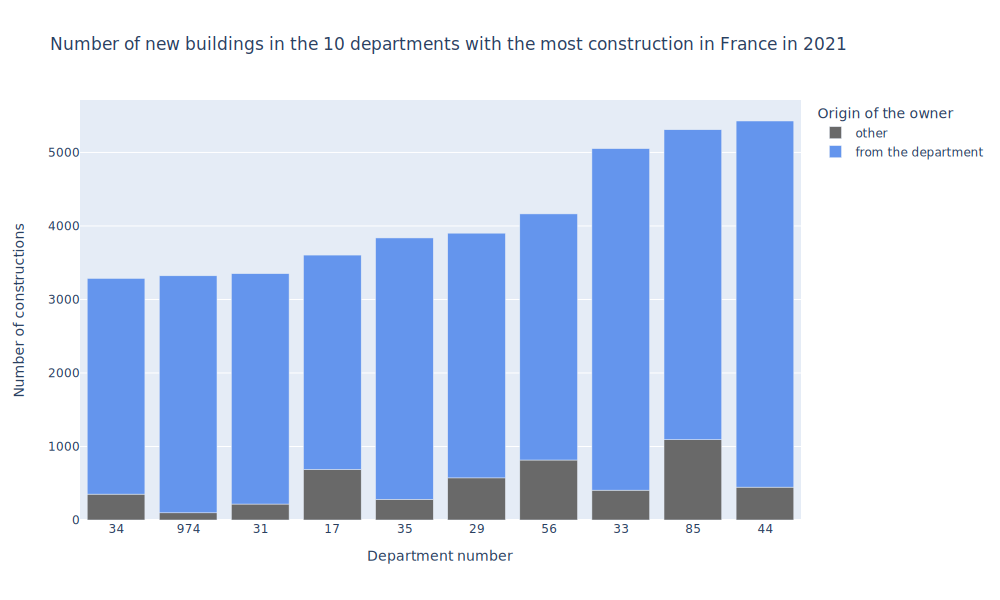

In [28]:
fig.show(renderer="svg")

For the 10 departments with the most constructions, 9 are coastal departments. More precisely, the 6 departments between Finistère and Gironde are all present in this top, so there is a very strong dynamic of the Atlantic coast.

We can also note the presence of 3 of the 4 Breton departments, which can be partly explained by the opening up of this region thanks to the creation of several TGV lines and a particularly attractive fiber coverage.

## Partie III: Case study on urban extension in Loire-Atlantique

## Quantitative Analysis

We can try to understand the dynamics at a local scale : municipal scale<br>
Nevertheless, this scale brings a major problem, it is difficult to understand and visualize the dynamics with a quantitative approach because the different indicators give different interpretations<br>
It is also difficult to define the indicator to use.
For example, should we take the number of buildings or the number of buildings divided by the population of the commune?


### Creation of a Geodataframe

In [29]:
dep_44=gpd.read_file(r'communes-loire-atlantique.geojson')


In [30]:
dep_44['geometry']=dep_44['geometry'].simplify(0.001)

### Indicator 1 : Number of constructions per municipality

In [31]:
com_sitadel=sitadel[['COMM', 'Num_DAU']].groupby(['COMM'], as_index=False).count()
##dep_sitadel01 = dep_sitadel01[dep_sitadel01['COMM'].str.startswith('01')] 

In [32]:
dep_44=dep_44.merge( com_sitadel, left_on='code_insee', right_on='COMM', how='left')
dep_44['Num_DAU'] = dep_44['Num_DAU'].fillna(0)

### Inidicator 2 : Number of new constructions per number of inhabitants

In [33]:
recensement_44=pd.read_csv('recensement_44_2022.csv', sep=';')

In [34]:
recensement_44['code_com']=recensement_44['Code commune'].apply(lambda x: com_code(x, 44))

In [35]:
dep_44=dep_44.merge( recensement_44, left_on='code_insee', right_on='code_com', how='left')

In [36]:
dep_44['con_by_h']=dep_44['Num_DAU']/dep_44['Population totale']*100

### Graphics and Analysis 

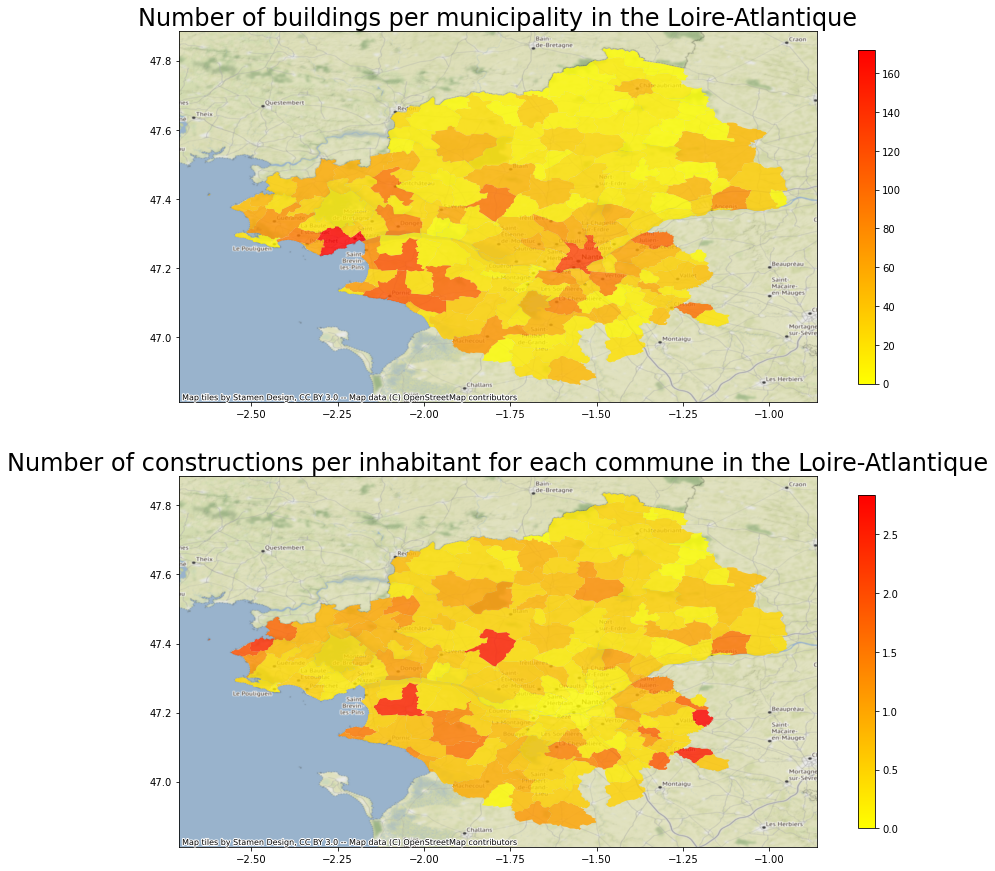

In [37]:
###definition du cadre
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

##ax1.axis('off')
#ax2.axis('off')
### name of graphics
ax1.set_title('Number of buildings per municipality in the Loire-Atlantique', fontsize=24)
ax2.set_title("Number of constructions per inhabitant for each commune in the Loire-Atlantique", fontsize=24)

###graphic matrix knn
ax1=dep_44.plot(ax=ax1,column='Num_DAU',  cmap='autumn_r', legend=True, alpha=0.8,  legend_kwds={'shrink': 0.9});
cx.add_basemap(ax1, crs=dep_44.crs)

###graphic matrix contiguity
ax2=dep_44.plot(ax=ax2, column='con_by_h',  cmap='autumn_r', legend=True, alpha=0.8,  legend_kwds={'shrink': 0.9});
cx.add_basemap(ax2, crs=dep_44.crs)


plt.show()

It is difficult to make an analysis based on these quantitative indexes. Another approach is to use spatial autocorrelation indexes. <br>
In this study we will use the moran index. The approach we are going to follow is taken from two sources :
<ul>
<li>this article from the insee: <a href="https://www.insee.fr/en/statistiques/fichier/3635545/imet131-g-chapitre-3.pdf">Chapter 3. Spatial autocorrelation indices</a>
</li> 
<li>and this lecture by D'Anselin, founder of spatial econometrics: <a href="https://www.youtube.com/watch?v=TeKN5SaabPs">Recorded lecture by Luc Anselin at the University of Chicago (October 2017)</a></li>   
</ul>

In spatial autocorrelation, the neighborhood is very important. We will therefore include the Vendée, a neighboring department which is also the second department with the most new constructions<br>
We will also use a coordinate reference system (CRS) allowing the calculation of distance for France: The Lambert 93 (epsg:2154) 

## Moran Index

### Change the CRS

In [38]:
dep_44=dep_44.to_crs('EPSG:2154')

### data structuration

In [39]:
dep_85=gpd.read_file(r'communes-17-charente-maritime.geojson')
dep_85=dep_85[['com_code', 'com_name', 'geometry' ]].copy()
dep_85=dep_85.rename(columns={'com_code':'code', 'com_name':'nom'})
dep_85=dep_85.to_crs('EPSG:2154')


In [40]:
dep_44=dep_44[['code_insee', 'libelle_long_norm', 'geometry']].copy()
dep_44=dep_44.rename(columns={'code_insee':'code', 'libelle_long_norm':'nom'})

In [41]:
dep_44_85=pd.concat([dep_44, dep_85])

In [42]:
dep_44_85=dep_44_85.merge( com_sitadel, left_on='code', right_on='COMM', how='left')
dep_44_85['Num_DAU'] = dep_44_85['Num_DAU'].fillna(0)

In [43]:
recensement_44=pd.read_csv('recensement_44_2022.csv', sep=';')
recensement_44['code_com']=recensement_44['Code commune'].apply(lambda x: com_code(x, 44))
recensement_85=pd.read_csv('recensement_85_2022.csv', sep=';')
recensement_85['code_com']=recensement_85['Code commune'].apply(lambda x: com_code(x, 85))



recensement_44_85=pd.concat([recensement_44, recensement_85])

In [44]:
dep_44_85=dep_44_85.merge( recensement_44_85, left_on='code', right_on='code_com', how='left')

## Moran Index with KNN matrix

In [45]:
y=dep_44_85['Num_DAU']

In [46]:
o= libpysal.weights.KNN.from_dataframe(dep_44_85, geom_col='geometry', k=10)

In [47]:
m=moran.Moran(y, o)

### global Index

In [48]:
print('moran global')
print(m.I)

moran global
0.23901009853574168


### local Index

In [49]:
m_local=moran.Moran_Local(y,o, permutations=100000)

In [50]:
dep_44_85['index_moran_classe']=m_local.q
dep_44_85['index_moran']=m_local.Is

### Randomization Test

In [51]:
if m.p_rand < 0.05:
    print('H0 is rejected, there is no randomization so there is global autocorrelation')
    ##indique les clusters avec q la classe et p_sim la p_value
    dep_44_85['p_value']= m_local.p_sim
else :
    print('H0 is accepted, there is randomization so there is no global autocorrelation')
    ##suit une loi normal
    dep_44_85['p_value']= m_local.p_z_sim*2

H0 is rejected, there is no randomization so there is global autocorrelation


### False Discovery Rate

In [52]:
test=fdr(dep_44_85['p_value'], 0.10)
dep_44_85['index_moran_cluster']=dep_44_85['index_moran_classe'].where(dep_44_85['p_value'] <= test).fillna(0)

### Graphic and Analysis 

In [53]:
dep_44_85['index_moran_cluster']=dep_44_85['index_moran_cluster'].apply(lambda x: moran_cluster(x))

In [54]:
color_dict = {'LL':'#b82e2e', 'LH':'#FC6955', 'HL':'#3283FE', 
              'HH':'#1223e0', 'non_significant':'#bab0ac'}

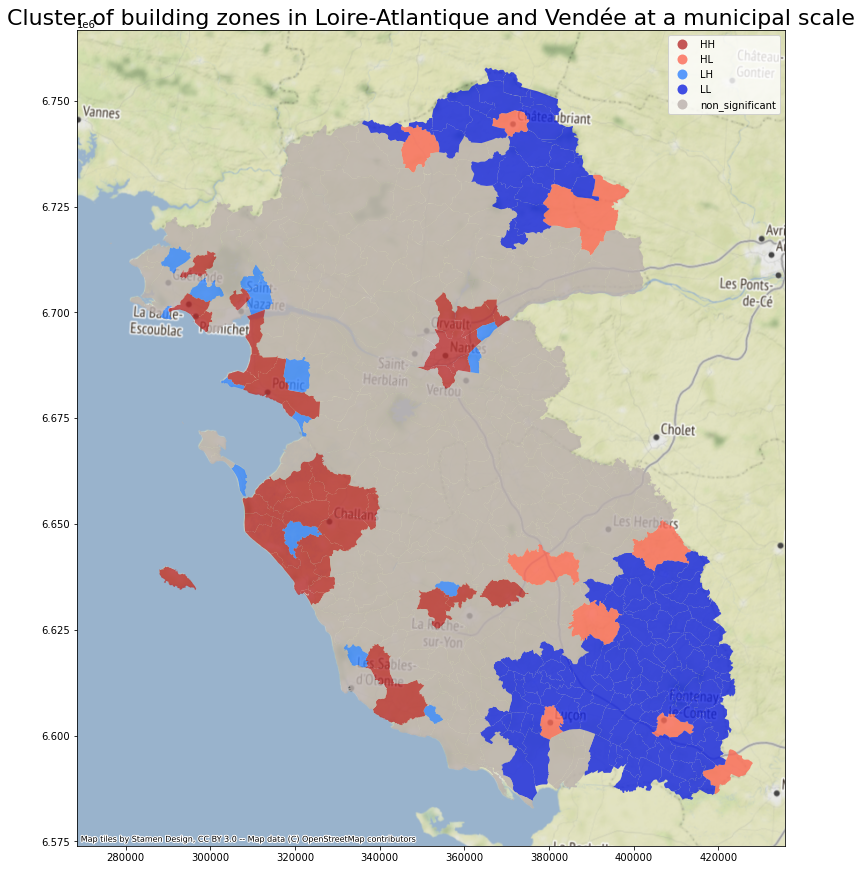

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax=dep_44_85.plot(ax=ax,column='index_moran_cluster',legend=True,alpha=0.8, legend_kwds={ 'bbox_to_anchor': (1, 1)},
              cmap=colors.ListedColormap(list(color_dict.values())))
plt.title("Cluster of building zones in Loire-Atlantique and Vendée at a municipal scale", fontdict={'fontsize': 22, 'fontweight': 'medium'})
cx.add_basemap(ax, crs='EPSG:2154')

The Moran index allows us to define 4 types of clusters: 
<ul>
<li>high-high clusters: presenting individuals with higher than average values surrounded by other individuals with higher than average values </li> 
<li>low-low clusters: presenting individuals with lower than average values surrounded by other individuals with lower than average values </li> 
<li>high-low clusters: presenting individuals with higher than average values surrounded by individuals with lower than average values </li>
<li>low-high clusters: presenting individuals with lower than average values surrounded by individuals with above average values</li>
</ul>
We can observe that the inland area is not very attractive compared to the coast and the Nantes agglomeration, which are the two areas with the strongest construction dynamics in the department. This confirms our hypothesis about the Atlantic coast and its attractiveness.

## Comparison of two neighborhood matrixes

To make sure that our analysis is not linked to a too specific neighborhood matrix, we run our analysis again with another method to create the matrix.<br> This method defines as a neighbor any individual having at least one common border or vertex with another individual.

### Moran Index with contiguity matrix

In [56]:
o=libpysal.weights.Voronoi(np.column_stack((dep_44_85.geometry.centroid.x , dep_44_85.geometry.centroid.y)))

In [57]:
m=moran.Moran(y, o)

### global Index

In [58]:
print('moran global')
print(m.I)

moran global
0.266292531422705


### local Index

In [59]:
m_local=moran.Moran_Local(y,o, permutations=100000)

In [60]:
dep_44_85['index_moran_classe_contiguity']=m_local.q
dep_44_85['index_moran_contiguity']=m_local.Is

### Randomization Test

In [61]:
if m.p_rand < 0.05:
    print('H0 is rejected, there is no randomization so there is global autocorrelation')
    ##indique les clusters avec q la classe et p_sim la p_value
    dep_44_85['p_value']= m_local.p_sim
else :
    print('H0 is accepted, there is randomization so there is no global autocorrelation')
    ##suit une loi normal
    dep_44_85['p_value']= m_local.p_z_sim*2

H0 is rejected, there is no randomization so there is global autocorrelation


### False Discovery Rate

In [62]:
test=fdr(dep_44_85['p_value'], 0.10)
dep_44_85['index_moran_cluster_contiguity']=dep_44_85['index_moran_classe_contiguity'].where(dep_44_85['p_value'] <= test).fillna(0)

In [63]:
dep_44_85['index_moran_cluster_contiguity']=dep_44_85['index_moran_cluster_contiguity'].apply(lambda x: moran_cluster(x))

### Graphic and Analysis 

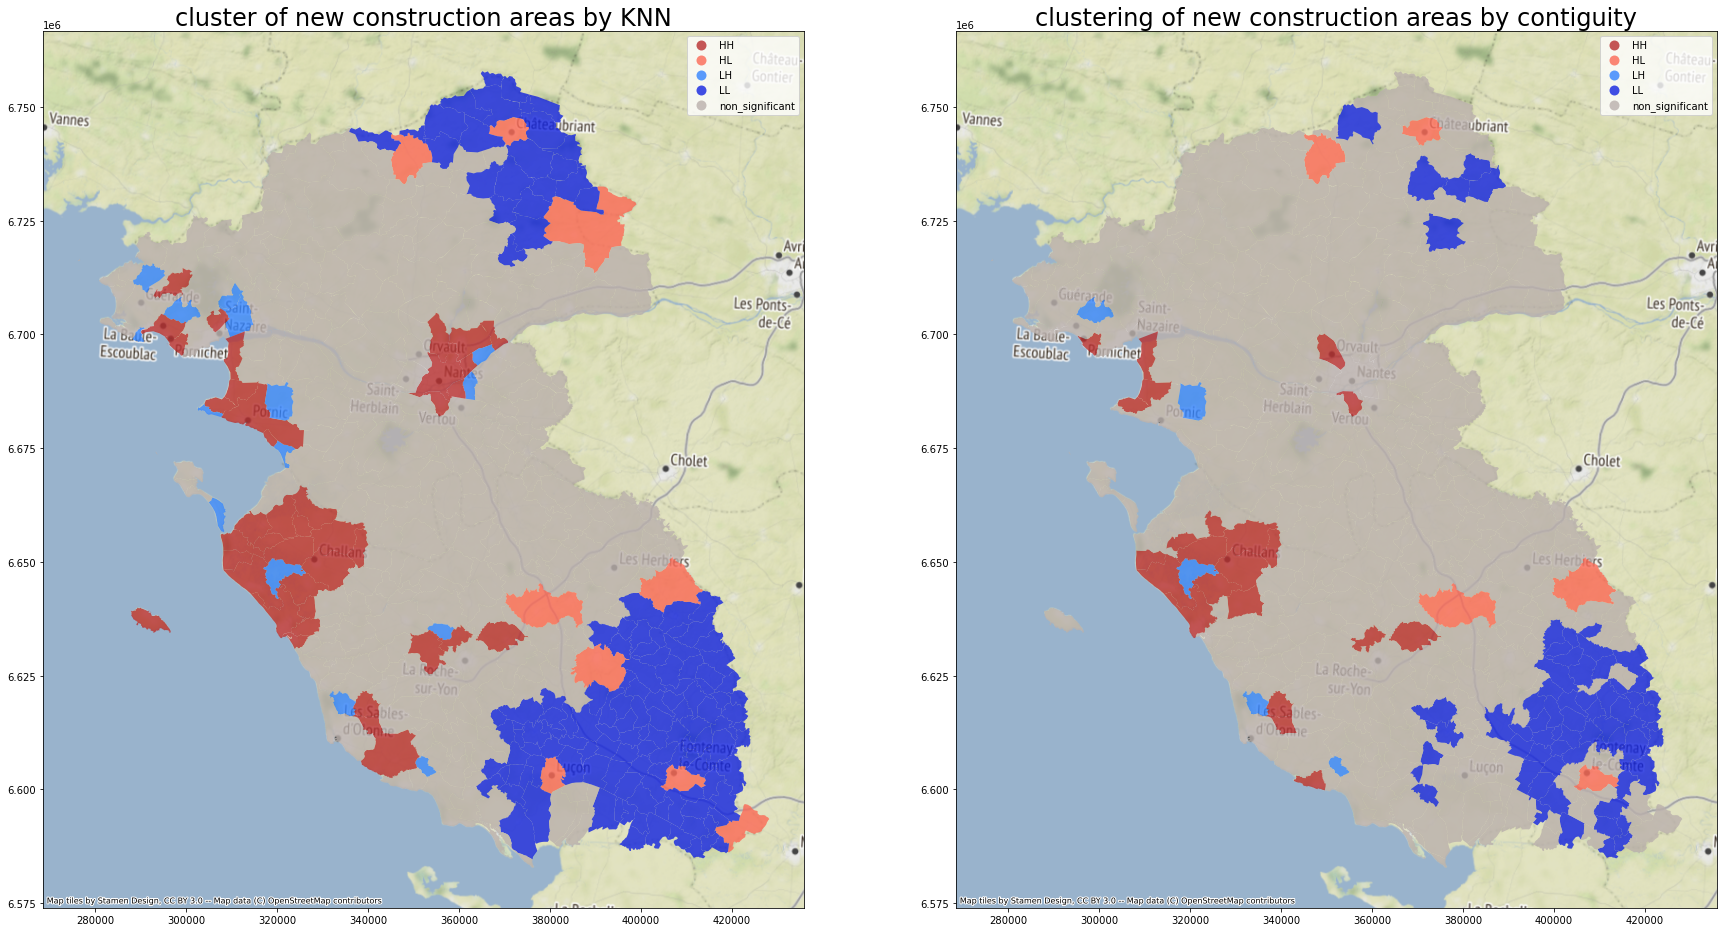

In [64]:

###definition du cadre
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30, 30))

##ax1.axis('off')
#ax2.axis('off')
### name of graphics
ax1.set_title('cluster of new construction areas by KNN', fontsize=24)
ax2.set_title('clustering of new construction areas by contiguity', fontsize=24)

###graphic matrix knn
ax1=dep_44_85.plot(ax=ax1,column='index_moran_cluster',legend=True, alpha=0.8, legend_kwds={ 'bbox_to_anchor': (1, 1)},
              cmap=colors.ListedColormap(list(color_dict.values())));
cx.add_basemap(ax1, crs=dep_44_85.crs)

###graphic matrix contiguity
ax2=dep_44_85.plot(ax=ax2,column='index_moran_cluster_contiguity',legend=True, alpha=0.8,
              cmap=colors.ListedColormap(list(color_dict.values())));
cx.add_basemap(ax2, crs=dep_44_85.crs)


plt.show()


We observe that the clusters are located in the same areas but are less extended with the adjacency matrix

## Conclusion

The year 2021 has been marked by numerous construction projects on the coasts and more particularly on the Atlantic coast.  In this area, the people behind the project build mostly in the department where they live (between 70% and 90%).<br>
We hypothesize two new dynamics that have appeared post-Covid: 
<ul>
<li>City dwellers from large cities (Nantes, Bordeaux) moving to areas near the sea to obtain a better living environment</li> 
<li>The construction of second homes for city dwellers who now have more days of teleworking</li>
</ul>
<p>Construction in coastal areas raises the question of adaptation to climate change, while the latest scenarios announced by the IPCC are particularly alarming. More precise geocoding and a year-by-year study would allow for more accurate conclusions.</p>